In [ ]:
# Install required packages.
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-geometric
!pip install -q ogb>=1.3.0

# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from time import time

from google.colab import widgets
from ipywidgets import interact, interact_manual, FloatSlider
import pandas as pd
import numpy as np
import torch

     |████████████████████████████████| 2.6MB 28.9MB/s 
     |████████████████████████████████| 1.5MB 31.8MB/s 
     |████████████████████████████████| 194kB 20.9MB/s 
     |████████████████████████████████| 235kB 45.6MB/s 
     |████████████████████████████████| 2.2MB 50.2MB/s 
     |████████████████████████████████| 51kB 7.9MB/s 


In [ ]:
# THIS CELL WILL DISAPPEAR SINCE IT WLL BE MOVED TO EXTERNAL SCRIPT

# DEFINE VISUALIZATION FUNCTIONS
import networkx as nx  # Graph manipulation library
from torch_geometric.utils import to_networkx  # Conversion function

def to_molecule(torch_graph, remove_isolated=True):
    G = to_networkx(
        torch_graph,
        to_undirected=True,
        node_attrs=["symbols"]
    )
    return G


def plot_mol(
    G: nx.Graph,
    edge_mask=None,
    edge_type=None,
    threshold=None,
    drop_isolates=None,
    ax=None
):
    if drop_isolates is None:
        drop_isolates = True if threshold else False
    if ax is None:
        fig, ax = plt.subplots(dpi=120)

    pos = nx.planar_layout(G)
    pos = nx.kamada_kawai_layout(G, pos=pos)

    if edge_type is None:
        widths = None
    else:
        widths = edge_type + 1

    edgelist = G.edges()

    if edge_mask is None:
        edge_color = 'black'
    else:
        if threshold is not None:
            edgelist = [
                (u,v) for u, v in G.edges() if edge_mask[(u,v)] > threshold
            ]

        edge_color = [edge_mask[(u, v)] for u, v in edgelist]
    
    nodelist = G.nodes()
    if drop_isolates:
        if not edgelist:  # Prevent errors
            print("No nodes left to show !")
            return

        nodelist = list(set.union(*map(set,edgelist)))

    node_labels = {
        node: data["symbols"] for node, data in G.nodes(data=True)
        if node in nodelist
    }

    nx.draw_networkx(
        G, pos=pos,
        nodelist=nodelist,
        node_size=200,
        labels=node_labels,
        width=widths,
        edgelist=edgelist,
        edge_color=edge_color, edge_cmap=plt.cm.Blues,
        edge_vmin=0., edge_vmax=1.,
        node_color='azure',
        ax=ax
    )

    if ax is None:
        fig.tight_layout()
        plt.show()


# Shedding light on obscure graph deep learning

Deep learning techniques on graphs have achieved impressive results in recent years. Graph neural networks (GNN) combine node feature information with the graph structure in order to make their predictions. However, this strategy results in complex models, whose predictions can be hard to interpret.

In this workshop, you will be introduced to graph data and you will learn the fundamental concepts behind graph neural networks. After building and training your own GNN, we will present GNNExplainer, a model-agnostic framework for interpreting GNN results. Thus, you will be able to visualize an explanation for your GNN's predictions.

# Working with graphs in Pytorch Geometric

Graphs are a powerful way to represent many real word data that contain structure. A graph is a pair $G=(V, E)$, where $V$ is a set of elements called vertices (or nodes) and $E$ is a set of edges (links), where an edge is an ordered pair of vertices. This way, edges encode relations among nodes.

In this workshop we will be working with [PyTorch Geometric][1], a handy extension of pytorch designed to work with graphs. A single graph in PyTorch Geometric is described by an instance of `torch_geometric.data.Data`, which can hold several attributes, among which:

* `data.x`: Node feature matrix with shape `[num_nodes, num_node_features]`

* `data.edge_index`: Graph connectivity in COO format with shape `[2, num_edges]` and type torch.long

* `data.edge_attr`: Edge feature matrix with shape `[num_edges, num_edge_features]`

* `data.y`: Target to train against, e.g., node-level targets of shape `[num_nodes, *]` or graph-level targets of shape `[1, *]`

Not all of these fields should be present and the user can define his own attributes. The following cell shows an example for the creation of a simple graph.

[1]: https://pytorch-geometric.readthedocs.io/en/latest/


In [ ]:
import torch
from torch_geometric.data import Data

edge_index = torch.tensor([[0, 1, 1, 2],
                           [1, 0, 2, 1]], dtype=torch.long)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

G1 = Data(x=x, edge_index=edge_index)

## Exercise 1
In order to familiarize yourself with Pytorch Geometric, complete the implementation of the following function, which takes a graph as input (which is a `torch_geometric.data.Data` object), and returns `True` if the graph is **un**directed, `False` if it is directed. We say that a graph is undirected if for each existing edge $(i, j)$ there is also the edge in the opposite direction, $(j,i)$. For simplicity,you may assume that the graph is connected (no isolated nodes) and there are no self loops.

In [ ]:
def is_undirected(graph):
  ## TODO: implement me!
  pass

# Solution (TO BE REMOVED)
def is_undirected(graph):
  pair_dict = {}
  for edge_idx in range(graph.edge_index.shape[1]):
    if graph.edge_index[0, edge_idx] < graph.edge_index[1, edge_idx]:
      key = (int(graph.edge_index[0, edge_idx]), int(graph.edge_index[1, edge_idx]))
    else:
      key = (int(graph.edge_index[1, edge_idx]), int(graph.edge_index[0, edge_idx]))
    if key in pair_dict.keys():
      pair_dict[key] -= 1
    else:
      pair_dict[key] = 1
  return not bool(np.sum(list(pair_dict.values())))



Now verify the correctness of the function you wrote by comparing the results with the available Pytorch Geometric `is_directed()` method.

In [ ]:
print("Your function works correctly on G1: ", G1.is_undirected() == is_undirected(G1))

# Let us check the result on a second graph
edge_index = torch.tensor([[0, 1, 1],
                           [1, 0, 2]], dtype=torch.long)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

G2 = Data(x=x, edge_index=edge_index)

print("Your function works correctly on G2: ", G2.is_undirected() == is_undirected(G2))

Your function works correctly on G1:  True
Your function works correctly on G2:  True


## Dataloading
Pytorch Geometric can be used to easily load and process several benchmark graph datasets. These include the Mutagenicity dataset, which are going to use in this workshop.

## Mutagenicity: a Molecule Classification Dataset
In this workshop we are going to work with the [Mutagenicity dataset][1], one of the datasets from the [TUDataset][2] collection. Each graph represents a molecule, where nodes are atoms, and edges are chemical bonds. Input node features are 14-dimensional and represent the one-hot-encoding for each atom, which can be one of 14 different elements. For each graph we are given a binary label which indicated whether a molecule has a [mutagenic effect][3] on the Gram-negative bacterium S. typhimurium.


[1]: https://pubs.acs.org/doi/abs/10.1021/jm040835a
[2]: https://ls11-www.cs.tu-dortmund.de/staff/morris/graphkerneldatasets
[3]: https://pubs.acs.org/doi/10.1021/jm00106a046

In [ ]:
# IMPORTS
from torch_geometric.datasets import TUDataset

#### Transforms

When loading a dataset, PyTorch Geometric lets the user pass some **transforms** to apply to the data. Here, we define the class `AddSymbols`, which sets the `symbols` attribute of each graph to be equal to the string representing that atom, which is retrieved from the features one-hot-encoding. This will be later useful for molecule visualization.

In [ ]:
# Atom types, ordered accroding to one-hot-encoding
MUT_LABEL_ENC = pd.Series(data = ["C","O", "Cl","H","N","F","Br","S","P","I","Na","K","Li","Ca"])
print("Number of different elements: ", len(MUT_LABEL_ENC))

# Define transform
class AddSymbols(object):
    """
    Add the symbol of the elements, from the atomic number, as a key of the graph
    """
    def __call__(self, graph):
        graph.symbols = MUT_LABEL_ENC.loc[graph.x.argmax(dim=-1)].values
       
        return graph

# Load the dataset
dataset = TUDataset(
    root=".", name="Mutagenicity",
    transform=AddSymbols(),
).shuffle()

Number of different elements:  14
Extracting ./Mutagenicity/Mutagenicity.zip
Processing...
Done!


In the previous exercise we have seen that Pytorch Geometric implements the convenient attribute `is_directed()`. Together with that, there are other useful dataset and graph attributes.

Let us use them to visualize some properties of the Mutagenetic dataset...

In [ ]:
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
print(f'Samples per class: {[ np.sum([1 for graph in dataset if graph.y == i ]) for i in range(dataset.num_classes) ]}')

all_atoms = np.concatenate(
    [graph.symbols for graph in dataset]
)
print(f"{len(np.unique(all_atoms))} unique atoms: {np.unique(all_atoms)}")



Dataset: Mutagenicity(4337):
Number of graphs: 4337
Number of features: 14
Number of classes: 2
Samples per class: [2401, 1936]
14 unique atoms: ['Br' 'C' 'Ca' 'Cl' 'F' 'H' 'I' 'K' 'Li' 'N' 'Na' 'O' 'P' 'S']


...and some properties of the first graph in the dataset.

In [ ]:
G = dataset[0]  # Get the first graph object.
print(G)
# Gather some statistics about the first graph.
print(f'Number of nodes: {G.num_nodes}')
print(f'Number of edges: {G.num_edges}')
print(f'Average node degree: {G.num_edges / G.num_nodes:.2f}')
print(f'Contains isolated nodes: {G.contains_isolated_nodes()}')
print(f'Contains self-loops: {G.contains_self_loops()}')
print(f'Is undirected: {G.is_undirected()}')

Data(edge_attr=[58, 3], edge_index=[2, 58], symbols=['C' 'C' 'C' 'N' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'H' 'H' 'H'
 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H'], x=[26, 14], y=[1])
Number of nodes: 26
Number of edges: 58
Average node degree: 2.23
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


## Visualization

To represent thhe molecules we will use `networkx`, a graph visualization library. The molecule visualization function `plot_mol` is written in the `visualization.py` script. It first converts a `torch_geometric.data.Data` object to a networkx objects by calling the pyTorch Geometric `to_networkx` function, and it then calls the `networkx.draw_networkx`.

The `interact` widget allows for easy visualization of the different molecules in the dataset.

In [ ]:
interact(
    lambda graph: plot_mol(
        to_molecule(dataset[graph]),
        edge_type=dataset[graph].edge_attr[:,0].numpy(),
    ),
    graph=range(len(dataset))
)

interactive(children=(Dropdown(description='graph', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,…

<function __main__.<lambda>>

## Batching in Pytorch Geometric
Neural networks typically work on batches of input data. For efficiency reasons, a Pytorch Geometric Dataloader builds a batch of graphs by considering it as a unique big graph: the big graph adjacency matrix is built by stacking diagonally the adjacency matrices of the graphs in the batch (defined by edge_index); features and target matrices are concatenated in the node dimension. This composition allows differing number of nodes and edges over examples in one batch.

$$  A =
  \begin{bmatrix}
    A_{1} & & \\
    & \ddots & \\
    & & A_{N}
  \end{bmatrix}, \quad X = \begin{bmatrix}
X_1\\ 
.\\ 
.\\ 
.\\ 
X_N
\end{bmatrix}, \quad Y = \begin{bmatrix}
Y_1\\ 
.\\ 
.\\ 
.\\ 
Y_N
\end{bmatrix}$$

A batch of graphs will contain the `batch` attribute, which is a tensor whose length is equal to the number of nodes in the big graphs obtained by the union of all the graphs in the batch. Such tensor maps each node to the index of the graph that nodes originally came from. Thus this allows for recovering the original graphs from a batch coming form the dataloader.

In [ ]:
from torch_geometric.data import DataLoader

loader = DataLoader(dataset, batch_size=32, shuffle=True)
data_batch = next(iter(loader))
print(data_batch)
print("Number of graphs in the batch:",data_batch.num_graphs)
#print(data_batch.batch)

Batch(batch=[939], edge_attr=[1912, 3], edge_index=[2, 1912], symbols=[32], x=[939, 14], y=[32])
Number of graphs in the batch: 32


# Graph neural networks

How can we operate on graph-structured data in a meaningful way?

Neural networks are typically made of several layers which compute latent representations of the initial input data. The fondamental layer of a GNN is called **graph convolution**. Even though there exists many types of graph convolution, here we will introduce the basic principles on which the idea relies. A graph convolution is a layer that computes the next nodes latent representation taking into account the structural information in a meaningful way. In order to understand graph convolution, we first need to understand what are the invariances and properties that this layer should ideally satisfy:

###1) Permutation invariance and equivariance

The idea is very simple. Suppose we want to perform a graph classification task. To work with node features, we typically stack them in a matrix $X \in \mathbb{R}^n\times\mathbb{R}^d$, being $n$ the number of nodes and $d$ the feature dimension. By doing so, we have introduced an ordering of the vertices. For a graph classification task it is clear that changing the vertex ordering (i.e.) permuting the vertices should not change the result. A function that satisfies this property is said to be **permutation invariant**. An example of permutation invariant function is the sum. In formulas, if $P$ is a permutation matrix, $X$ is the feature matrix and $A$ the adjacency matrix of the graph, permutation invariance can be written as $f(X, A) = f(PX, PAP^T)$. Note that $PX$ indicated the permuted vertices while $PAP^T$ indicates the corresponding permuted adjacency matrix (in which of course both rows and columns need to be permuted).
Analogously, if we want to perform a node classification task, we would like a permutation of the node ordering to be exactly reflected in the result (we want the node predictions to follow the same permutation as the input and not to remain the same, of course). This concept is called **permutation equivariance** and in formulas becomes $f(PX, PAP^T) = P(f(X))$. Depending on the specific task, graph convolution should satisfy these properties.

###2)  Locality

As happens for images convolution, graph convolution should also exploit the concept of locality, meaning that nodes in a neighborhood $\mathcal{N}(x_i)$ of the considered node $x_i$ should influence the computation of its latent representation.

## Graph Convolution

Having in mind the desired properties that graph convolution should satisfy, we can conclude that graph convolution should be a function having the following structure

$f(X, A) = \begin{pmatrix}
g(x_1, \mathcal{N}(x_1))\\ 
g(x_2, \mathcal{N}(x_2))\\ 
\dots\\
g(x_N, \mathcal{N}(x_N))\end{pmatrix}$

Note that $g$ should not depend on the order in which we consider the neighborhood nodes, meaning that $g$ must be a permutation invariant function. Furthermore, as happens in classic image convolution, the function $g$ is the same in each row, meaning that the learnable parameters are the same. This dramatically reduces the number of learnable parameters.

In this notebook, we introduce one example of convolution layer, as proposed by ([Morris et al. (2018)](https://arxiv.org/abs/1810.02244)). The layer works as follows:

$$
\mathbf{x}_v^{(\ell+1)} = \mathbf{W}^{(\ell + 1)}_1 \mathbf{x}_v^{(\ell)} + \mathbf{W}^{(\ell + 1)}_2 \sum_{w \in \mathcal{N}(v)} \mathbf{x}_w^{(\ell)}
$$

where $\mathbf{W}_i^{(\ell + 1)}$ denotes a trainable weight matrix of shape `[num_output_features, num_input_features]`, for $i \in \{ 1, 2 \}$. Note that we sum all the feature vectors in the neighborhood of node $i$, which exploits locality and guarantees permutation invariance.



## Exercise 2

Implement by yourself the graph convoluiton layer proposed above, by completing the implementation of the following class.

In [ ]:
## TODO: Implement me!
class GraphConvolution(torch.nn.Module):
  def __init__(self, num_input_features, num_output_features):
    super().__init__()
    W1 = 
  def forward(data):


## Implementing your first GNN in Pytorch Geometric
Conveniently, the graph convolution layer we have introduced above is implemented in Pytorch Geometric, under the name [`GraphConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GraphConv). We can now use it to build our first graph convolution network!



## Graph-level classification of molecules

We have seen that graph convolution is used to compute latent representation of the nodes in a graph. Depending on the specific task we need to perform, we will then use the last layer latent representations differently. An example is given in the following image.

TODO:Update image.

TODO: add images with explanations fo different tastks 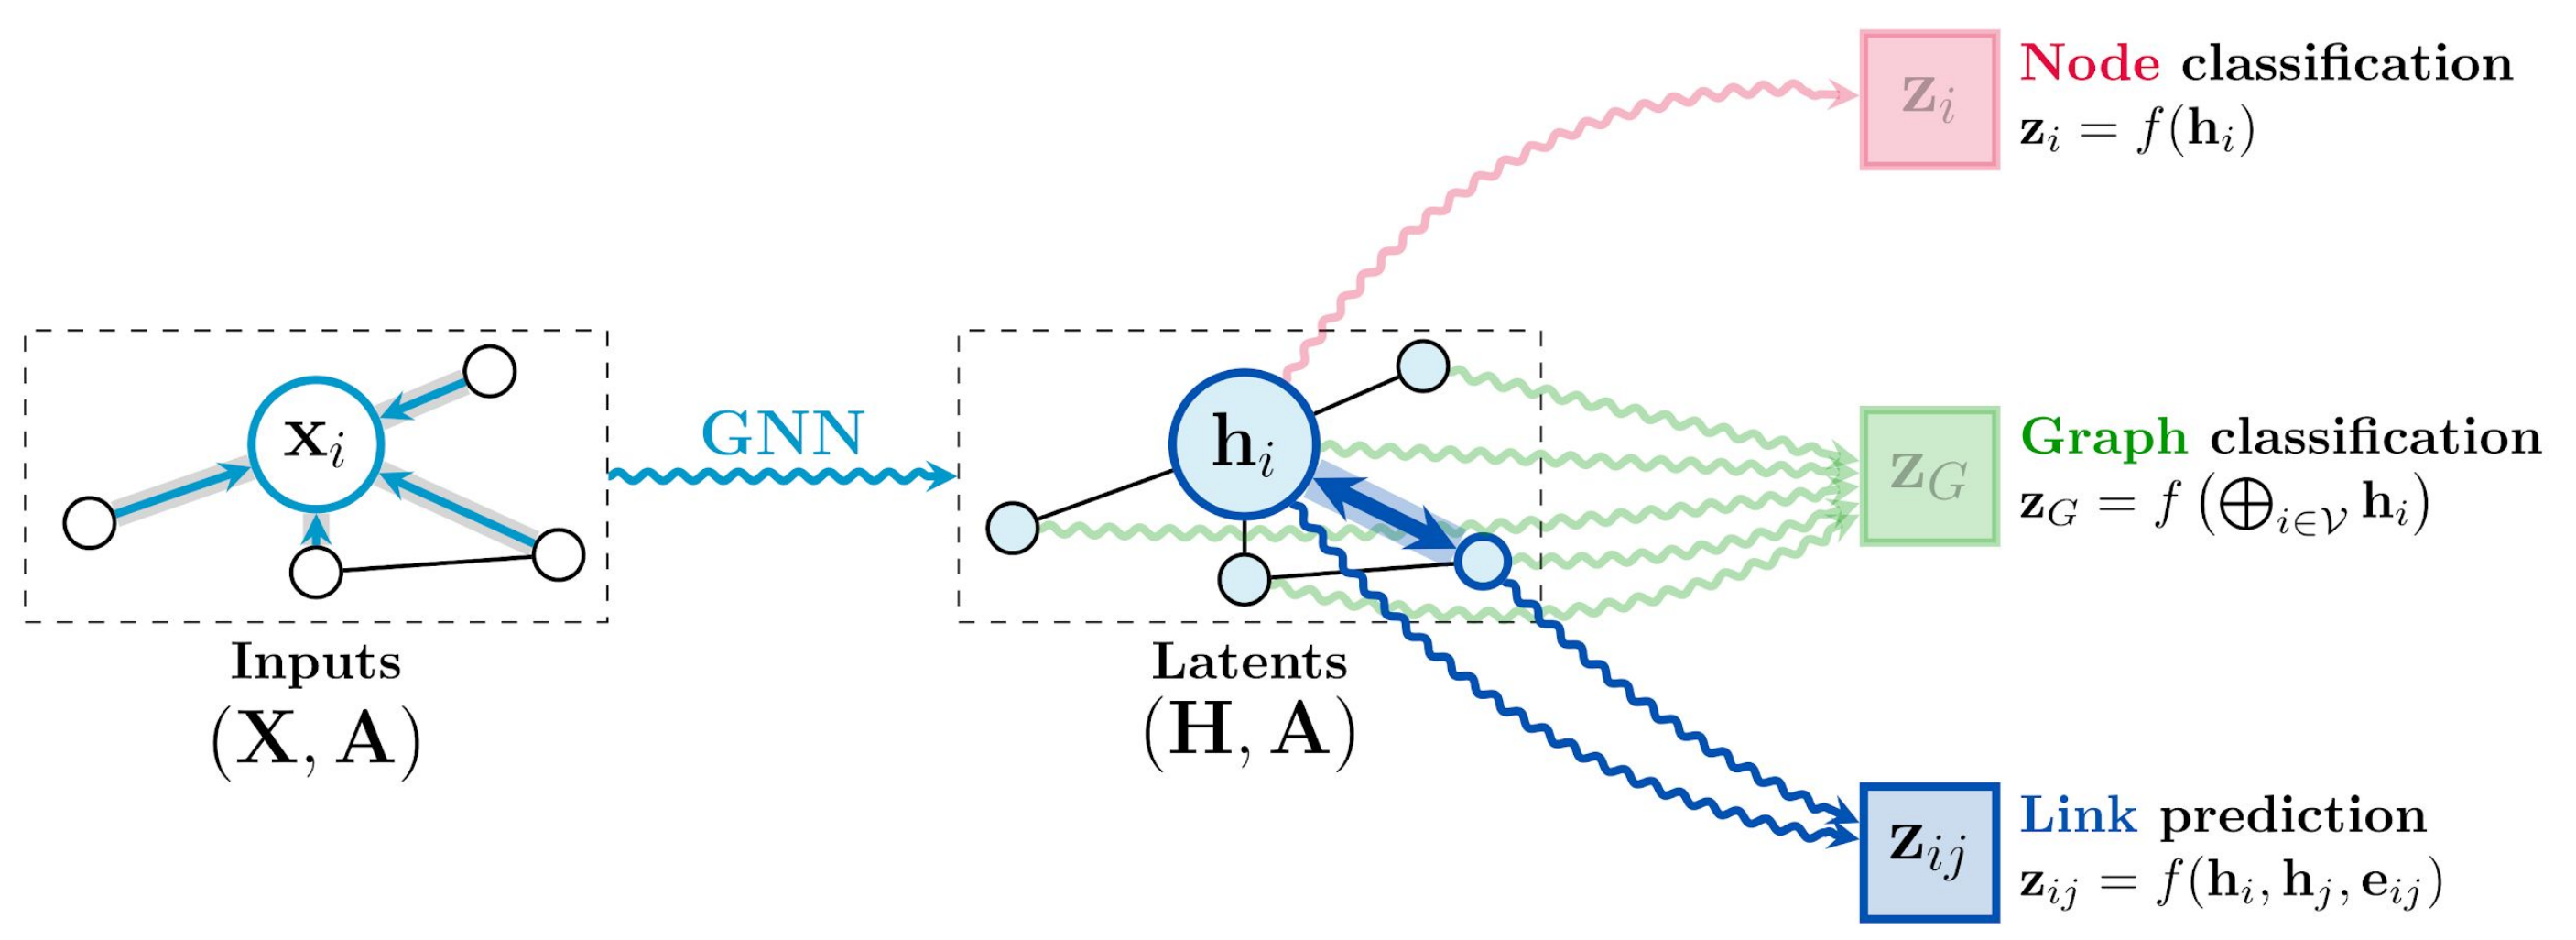

Remember that we are working on a graph classification task on the Mutagenicity dataset. This means that, after applying some convolution layers, we need to aggregate the node latent representations using a permutation invariant function. To this end, we will use the `global_add_pool` function. `global_add_pool` returns graph-level-outputs by adding node features across the node dimension, so that for a single graph $G_i$ its output is computed by
$$r_i = \sum_i ^N x_i.$$ `global_add_pool` takes as input the feature matrix `x` of the big batch graph and the `batch` tensor (see the section "Batching in Pytorch Geometric, above"). The batch tensor is used to correctly aggregate the node features within each graph in the batch.

## Exercise 3 (Network architecture)

Complete the missing parts in the implementation of the following GNN class. Define the convolution layers using the available GraphConv layer and keep the hidden layer feature dimension constant among the convolution layers. We first want to apply 5 convolutions (a relu activation is applied after each convolution). We then perform the global_add_pooling and conclude with two fully connected layers and a dropout.




In [ ]:
# IMPORTS
from torch.nn import Linear, NLLLoss, Sigmoid, LogSoftmax
import torch.nn.functional as F
from torch_geometric.nn import GraphConv, global_add_pool

##TODO: Implement me! :)
class GNN(torch.nn.Module):
    def __init__(
        self,
        hidden_channels,
        hidden_nodes,
        node_features=dataset.num_node_features,
        edge_features=dataset.num_edge_features
    ):
        super(GNN, self).__init__()
        self.hidden_channels = hidden_channels

        # Implement me!
        self.conv1 = 
        self.conv2 = 
        self.conv3 = 
        self.conv4 = 
        self.conv5 = 

        # Implement me!
        self.fc1 = 
        self.fc2 = Linear(hidden_channels, dataset.num_classes)

        self.readout = LogSoftmax(dim=-1)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        # Implement me!
        x = 
        x = 
        x = 
        x = 
        x = global_add_pool(x, batch)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.fc2(x)
        
        return self.readout(x)



## Solution (To be removed)
class GNN(torch.nn.Module):
    def __init__(
        self,
        hidden_channels,
        hidden_nodes,
        node_features=dataset.num_node_features,
        edge_features=dataset.num_edge_features
    ):
        super(GNN, self).__init__()
        self.hidden_channels = hidden_channels

        self.conv1 = GraphConv(node_features, hidden_channels)
        self.conv2 = GraphConv(hidden_channels, hidden_channels)
        self.conv3 = GraphConv(hidden_channels, hidden_channels)
        self.conv4 = GraphConv(hidden_channels, hidden_channels)
        self.conv5 = GraphConv(hidden_channels, hidden_channels)

        self.fc1 = Linear(hidden_channels, hidden_channels)
        self.fc2 = Linear(hidden_channels, dataset.num_classes)

        self.readout = LogSoftmax(dim=-1)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = F.relu(self.conv3(x, edge_index))
        x = F.relu(self.conv4(x, edge_index))
        x = F.relu(self.conv5(x, edge_index))
        x = global_add_pool(x, batch)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.fc2(x)
        
        return self.readout(x)

## Training
We are now ready to train our first GNN![link text](https:// [link text](https://))

In [ ]:
from torch_geometric.data import DataLoader
from tqdm.auto import tqdm

# If possible, we use a GPU
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
def test(model, loader):
    model.eval()

    y_preds = []
    y_trues = []

    for data in loader:  # Iterate in batches over the training/test dataset.
        data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        y_preds.append(out.argmax(dim=1))  # Use the class with highest probability.
        y_trues.append(data.y)  # Check against ground-truth labels.
    
    y_pred = torch.cat(y_preds).flatten()
    y_true = torch.cat(y_trues).flatten()

    return torch.sum(y_pred == y_true).item() / len(y_true)  # Derive ratio of correct predictions.

In [ ]:
idx_tr, idx_val, idx_te = int(len(dataset) * .5) , int(len(dataset) * .7), len(dataset)

# NOTE: time per epoch by batch_size
# 128 -> 5.35s
# 256 -> 5.20s
batch_size = 128

loader_tr = DataLoader(dataset[:idx_tr], batch_size=batch_size, shuffle=True)
loader_val = DataLoader(dataset[idx_tr:idx_val], batch_size=batch_size, shuffle=True)
loader_te = DataLoader(
    dataset[idx_val:],
    batch_size=(idx_te - idx_val),
    shuffle=False
)

In [ ]:
model = GNN(
    hidden_channels=64,
    hidden_nodes=64
).to(device)
optimizer = torch.optim.Adam(params=model.parameters())
loss_function = NLLLoss()

# We prepare some empy lists to log the training progress
train_losses = []
train_accs = []
val_accs = []

In [ ]:
for epoch in tqdm(range(50)):
    epoch_loss = 0
    for batch in tqdm(loader_tr, leave=False):
        batch.to(device)
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, batch.batch)
        loss = loss_function(out, batch.y.flatten())
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            epoch_loss += loss.item()

    with torch.no_grad():
        train_accs.append(test(model, loader_tr))
        val_accs.append(test(model, loader_val))
        train_losses.append(epoch_loss)

In [ ]:
# Let's save the model for future usage

torch.save(model.state_dict(), "mol_classifier.pt")

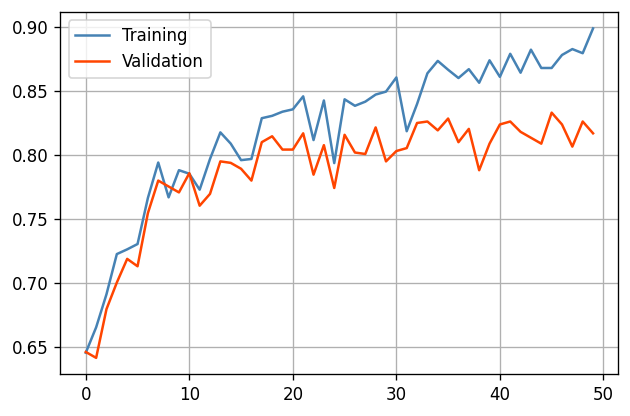

In [ ]:
# TRAINING VISUALIZATION

fig, ax = plt.subplots(dpi=120)

ax.plot(train_accs, c="steelblue", label="Training")
ax.plot(val_accs, c="orangered", label="Validation")
ax.grid()
ax.legend()

plt.show()

### Evaluation

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
with torch.no_grad():
    model.eval()

    test_batch = next(iter(loader_te)).to(device)

    y_pred = model(test_batch.x, test_batch.edge_index, test_batch.batch).argmax(dim=1)
    y_true = test_batch.y


In [ ]:
cm = confusion_matrix(y_true.flatten().cpu(), y_pred.cpu())
print(f"""
Confusion matrix:
{cm}

Accuracy: {
    ((y_true.flatten().cpu() == y_pred.cpu()).sum() / len(y_pred)).item()
}
""")


Confusion matrix:
[[627 113]
 [154 408]]

Accuracy: 0.7949308753013611



## Explainability

This is the second part of this workshop.

We will focus on how to gain insight from the trained model. To this end, we introduce [GNN Explainer][1], a general,  model-agnostic approach for providing interpretable explanations for predictions of any GNN-based model on any graph-based machine learning task.

The notebook is organized as follows:

* Brief theoretical recap on GNN-EXPLAINER
* Train your GNN-EXPLAINER to explain graph classification predictions
* Visualize and understand the proposed explanation

[1]: https://github.com/RexYing/gnn-model-explainer

In [ ]:
from math import sqrt
from copy import deepcopy

from torch_geometric.nn import MessagePassing
from torch_geometric.data import Data
EPS = 1e-15


class GNNExplainer(torch.nn.Module):
    """The GNN-Explainer model from the `"GNNExplainer: Generating
    Explanations for Graph Neural Networks"
    <https://arxiv.org/abs/1903.03894>`_ paper for identifying compact subgraph
    structures and small subsets node features that play a crucial role in a
    GNN’s graph-prediction.
    """

    coeffs = {
        'edge_size': 0.001,
        'node_feat_size': 1.0,
        'edge_ent': 1.0,
        'node_feat_ent': 0.1,
    }

    def __init__(self, model, epochs=100, lr=0.01, log=True):
        """ Initialize GNNExplainer Class.

        Args:
            model (torch.nn.Module): The GNN module to explain.
            epochs (int, optional): The number of epochs to train.
                (default: :obj:`100`)
            lr (float, optional): The learning rate to apply.
                (default: :obj:`0.01`)
        """
        super(GNNExplainer, self).__init__()
        self.model = model
        self.epochs = epochs
        self.lr = lr
        self.log = log

    def __set_masks__(self, x, edge_index):
        """ Initialize the masks for edges and node features.

        For each module contained in the GNN model, the attribute
        __edge_mask__ is set to the initialized edge mask, so that
        this is automatically taken into account during message passing.

        Args:
            x (torch tensor): node features
            edge_index (torch tensor): pytorch geometric edge index
        """
        (N, F), E = x.size(), edge_index.size(1)

        # Node feature mask.
        self.node_feat_mask = torch.nn.Parameter(torch.randn(F) * 0.1)

        # Edge mask.
        std = torch.nn.init.calculate_gain('relu') * sqrt(2.0 / (2 * N))
        edge_mask = torch.randn(E) * std
        self.edge_mask = torch.nn.Parameter(edge_mask)
        # TODO: at some point we should enforce the mask to be symmetric?
        # Maybe do this iteratively in explain graph? --> but then should
        # maybe reset the module.__edge_mask__ as below

        for module in self.model.modules():
            if isinstance(module, MessagePassing):
                module.__explain__ = True
                module.__edge_mask__ = self.edge_mask

    def __clear_masks__(self):
        """Deletes the node and edge masks.
        """
        for module in self.model.modules():
            if isinstance(module, MessagePassing):
                module.__explain__ = False
                module.__edge_mask__ = None
        self.node_feat_masks = None
        self.edge_mask = None

    # NOTE: Have the audience implement the loss, based on theoretical explanation.
    def __graph_loss__(self, pred_proba, pred_label):
        """Computes the explainer loss function for explanation
        of graph classificaiton tasks.

        Args:
            pred_proba: predicted probabilities for the different
                classes from the model on the masked input
            pred_label: model prediction on the entire original
                graph (i.e. not masked in features or edges)
        Returns:
            loss (torch.tensor): explainer loss function, which
                is a weight sum of different terms.

        """
        # Prediction loss.
        # TODO: 0 removes the batch dimension? So this works only
        # for batchsize = 1 currently?
        loss = -torch.log(pred_proba[0, pred_label])


        # Edge mask size loss.
        edge_mask = self.edge_mask.sigmoid()
        loss = loss + self.coeffs['edge_size'] * edge_mask.sum()

        # Edge mask entropy loss.
        ent = -edge_mask * torch.log(edge_mask + EPS) - (1 - edge_mask) * torch.log(1 - edge_mask + EPS)
        loss = loss + self.coeffs['edge_ent'] * ent.mean()

        # Feature mask size loss.
        feat_mask = self.node_feat_mask.sigmoid()
        loss = loss + self.coeffs['node_feat_size'] * feat_mask.mean()

        return loss

    def explain_graph(self, data, **kwargs):
        """Learns and returns a node feature mask and an edge mask that play a
        crucial role to explain the prediction made by the GNN for graph
        classification.

        Args:
            x (Tensor): The node feature matrix.
            edge_index (LongTensor): The edge indices.
            batch_index (LongTensor): The batch index.

            **kwargs (optional): Additional arguments passed to the GNN module.

        Returns:
            (torch.tensor, torch.tensor): the node feature mask and edge mask
        """

        if len(data.y) > 1:
            raise NotImplementedError(f"Can only explain one molecule, recieved {len(data.y)}")

        self.model.eval()
        self.__clear_masks__()

        # Get the initial prediction.
        with torch.no_grad():
            model_pred = self.model(data.x ,data.edge_index, data.batch, **kwargs)

            probs_Y = torch.softmax(model_pred, 1)
            pred_label = probs_Y.argmax(dim=-1)
        
        print(f"Explaining prediction in class {pred_label.item()} (true class {data.y.item()})")

        self.__set_masks__(data.x, data.edge_index)
        self.to(data.x.device)

        optimizer = torch.optim.Adam([self.node_feat_mask, self.edge_mask],
                                     lr=self.lr)

        # epoch_losses = []

        for epoch in range(1, self.epochs + 1):
            # epoch_loss = 0
            optimizer.zero_grad()

            # Mask node features
            h = data.x * self.node_feat_mask.view(1, -1).sigmoid()

            model_pred = self.model(h, data.edge_index, data.batch, **kwargs)
            pred_proba = torch.softmax(model_pred, 1)
            loss = self.__graph_loss__(pred_proba, pred_label)
            loss.backward()
            # print("egde_grad:",self.edge_mask.grad)

            optimizer.step()
            # epoch_loss += loss.detach().item()
            # print('Epoch {}, loss {:.4f}'.format(epoch, epoch_loss))
            # epoch_losses.append(epoch_loss)

        node_feat_mask = self.node_feat_mask.detach().sigmoid()
        edge_mask = self.edge_mask.detach().sigmoid()

        self.__clear_masks__()

        return node_feat_mask, edge_mask



In [ ]:
from collections import defaultdict

def aggregate_edge_directions(edge_mask, data):
    """
    Conver an `edge_mask` in pytorch geometric format to a networkx compatible
    dictionary (_{(n1, n2) : mask_value}_).
    Multiple edge appearences are averaged.
    """
    edge_mask_dict = defaultdict(float)
    counts = defaultdict(int)

    for val, u, v in list(zip(edge_mask, *data.edge_index)):
        u, v = u.item(), v.item()
        if u > v:
            u, v = v, u
        edge_mask_dict[(u, v)] += val
        counts[(u,v)] += 1

    for edge, count in counts.items():
        edge_mask_dict[edge] /= count

    return edge_mask_dict


def explain_graph_visualized(data):
    data.to(device)
    x = data.x
    edge_index = data.edge_index

    print(f'Number of nodes: {x.shape[0]}')
    print(f'Number of edges: {edge_index.shape[1]}')

    # Initialize explainer
    explainer = GNNExplainer(model, epochs=200).to(device)
    # Train explainer
    GNNExp_feat_mask, GNNExp_edge_mask = explainer.explain_graph(data)

    mol = to_molecule(data)

    GNNExp_edge_mask_dict = aggregate_edge_directions(
       GNNExp_edge_mask.to("cpu").numpy(),
       data.to("cpu")
    )

    def threshold_plot(threshold):
        fig, ax = plt.subplots(
            1, 2,
            sharex=True,
            sharey=True,
            dpi=120, figsize=(9,4)
        )
    
        plot_mol(
            mol,
            GNNExp_edge_mask_dict,
            edge_type=2 * (data.edge_attr.argmax(dim=1) + 1).to("cpu").numpy(),
            threshold = threshold,
            ax=ax[0]
        )
    
        plot_mol(mol, ax=ax[1])

        plt.show()

    return interact(
        threshold_plot,
        threshold=FloatSlider(value=0.1, min=0., max=.99, step=0.05)
    )

In [ ]:
def big_interact(which):
    idces = []
    test_size = len(y_true)
    if which == "true_pos":
        idces += [
            i for i in range(test_size)
            if y_pred[i] == y_true[i] == 0
        ]
    if which == "true_neg":
        idces += [
            i for i in range(test_size)
            if y_pred[i] == y_true[i] == 1
        ]
    if which == "false_neg":
        idces += [
            i for i in range(test_size)
            if y_pred[i] != y_true[i] == 0
        ]
    if which == "false_pos":
        idces += [
            i for i in range(test_size)
            if y_pred[i] != y_true[i] == 1
        ]

    single_loader_te = DataLoader(
        dataset[idx_val:], batch_size=1, shuffle=False
    )
    return interact(
        lambda number: explain_graph_visualized(number),
        number=[graph for i, graph in enumerate(list(single_loader_te)) if i in idces],
    )

In [ ]:
interact(big_interact, which = ["true_pos", "true_neg", "false_pos", "false_neg"])

interactive(children=(Dropdown(description='which', options=('true_pos', 'true_neg', 'false_pos', 'false_neg')…

<function __main__.big_interact>

In [ ]:
test


<function __main__.test>